<h1><center>SAP IES AICOE TAKE-HOME TEST </center></h1>
<h2><center> Machine Learning </center></h2>

# Please choose <font color="red">ONLY 1</font> part of your interest: either Part A or B

# <font color="blue">Part A</font>

## Guideline:

- File to use: **contract_dataset_v20220109.csv**
- Train a **MULTI-CLASS CLASSIFICATION MODEL**. Your final model should be able to take in a test clause (column `provision`) and predict its provision type (column `label`). 
- Perform your own train-test split.
- Choose your own evaluation metrics and explain your choice(s).
- You may refer to, and/or copy code blocks from any public Github repositories, Kaggle kernels or tutorials online. However, please add a comment indicating the source.
- You are free to conduct exploratory data analysis, write unit tests or any other additional steps as you find neccesary.
- The purpose is NOT to train the best-performing model. It is to help us assess your ability to learn and apply NLP modelling techniques.

## Answer:

## Importing data

In [3]:
# Put your code here
import pandas as pd

df = pd.read_csv("../data/contract_dataset_v20220109.csv")

## Data Preparation

In [4]:
df.head()

,provision,label,source,Contract_Dates,Passwords
0,Borrower and any endorsers or guarantors hereo...,['waivers'],2019/QTR1/000143774919001296/ex_133310.htm,Offer Expiration Date: 6/30/2025,0HT@a@z)jz%
1,"No failure to exercise, and no delay in exerci...",['waivers'],2019/QTR1/000149315219002427/ex10-1.htm,Offer Expiration Date: 7/5/2023,v&-TAdyt
2,Until the Discharge of Senior Lender Claims ha...,['waivers'],2019/QTR1/000114420419010508/tv513897_ex10-25.htm,Contract Start Date: 1 27 2024,ijwepC|Y:Og
3,Neither Party shall be deemed to have waived a...,['waivers'],2019/QTR1/000148881319000009/a1022cobaltagreem...,Offer Expiration Date: 9/2/2023,sYJA +T#t
4,No waiver of the provisions hereof shall be va...,['waivers'],2019/QTR1/000114420419011984/tv514470_ex10-15.htm,Contract Start Date: 4 august 2021,9~$z3TJ0N|F!Oep


In [14]:
df.shape

(34549, 5)

In [5]:
df['label'].value_counts()

['governing laws']            12522
['counterparts']               9256
['amendments']                 4795
['terminations']               3748
['waivers']                    3274
['warranties']                  607
['valid issuances']             129
['government regulations']      127
['trade relations']              53
['trading activities']           38
Name: label, dtype: int64

We can observe that the dataset has class imbalance 

### Train Test Split

In [6]:
from sklearn.model_selection import train_test_split
X = df['provision']
y=df['label']

train_data, test_data = train_test_split(df, test_size=0.2, random_state=42,stratify=y)

The stratify parameter is essential for preserving the class distribution ratio of the original dataset in both the train and test splits. This is critical when dealing with imbalanced datasets to avoid a situation where the training data predominantly comprises the majority class.



### Text Vectorization

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

X_train = vectorizer.fit_transform(train_data['provision'])
y_train = train_data['label']

X_test = vectorizer.transform(test_data['provision'])
y_true = test_data['label']


### Feature Scaling

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.toarray())
X_test=scaler.transform(X_test.toarray())

### Handling class imbalance
By using SMOTE for oversampling, it creates synthetic samples for minority classes so that we have sufficient data to train the model. 

In [9]:
y_train.value_counts()

['governing laws']            10018
['counterparts']               7405
['amendments']                 3836
['terminations']               2998
['waivers']                    2619
['warranties']                  486
['valid issuances']             103
['government regulations']      102
['trade relations']              42
['trading activities']           30
Name: label, dtype: int64

In [10]:
from imblearn.over_sampling import SMOTE
sm=SMOTE(random_state=2)
X_train_res, y_train_res=sm.fit_resample(X_train,y_train)


In [100]:
y_train_res.value_counts()

['governing laws']            10018
['terminations']              10018
['counterparts']              10018
['amendments']                10018
['waivers']                   10018
['trading activities']        10018
['warranties']                10018
['government regulations']    10018
['valid issuances']           10018
['trade relations']           10018
Name: label, dtype: int64

## Training the model

### Random Forest

In [109]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(class_weight='balanced',n_estimators=100, random_state=42, max_depth=5) 
rf_model.fit(X_train_res, y_train_res)

RandomForestClassifier(class_weight='balanced', max_depth=5, random_state=42)

### Evaluation of model

I use the accuracy metric as I accounted for class imbalance by using SMOTE so there are approximately equal number of samples in each class. 


I used classification report to show precision, recall, f1-score and support for each class. 


Confusion Matrix is also used to show the overall performance of the model, giving a detailed breakdown of all the true positives, false positives, true negatives and false negatives.



In [111]:
from sklearn.metrics import accuracy_score, classification_report
y_rf_pred = rf_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_true, y_rf_pred)}")
print(f"Classification Report:\n{classification_report(y_true, y_rf_pred)}")

Accuracy: 0.9439942112879884
Classification Report:
                            precision    recall  f1-score   support

            ['amendments']       0.90      0.79      0.84       959
          ['counterparts']       0.99      0.99      0.99      1851
        ['governing laws']       1.00      0.99      0.99      2504
['government regulations']       0.48      0.96      0.64        25
          ['terminations']       0.89      0.95      0.92       750
       ['trade relations']       1.00      1.00      1.00        11
    ['trading activities']       0.67      1.00      0.80         8
       ['valid issuances']       0.81      1.00      0.90        26
               ['waivers']       0.86      0.84      0.85       655
            ['warranties']       0.67      0.83      0.74       121

                  accuracy                           0.94      6910
                 macro avg       0.83      0.94      0.87      6910
              weighted avg       0.95      0.94      0.94     

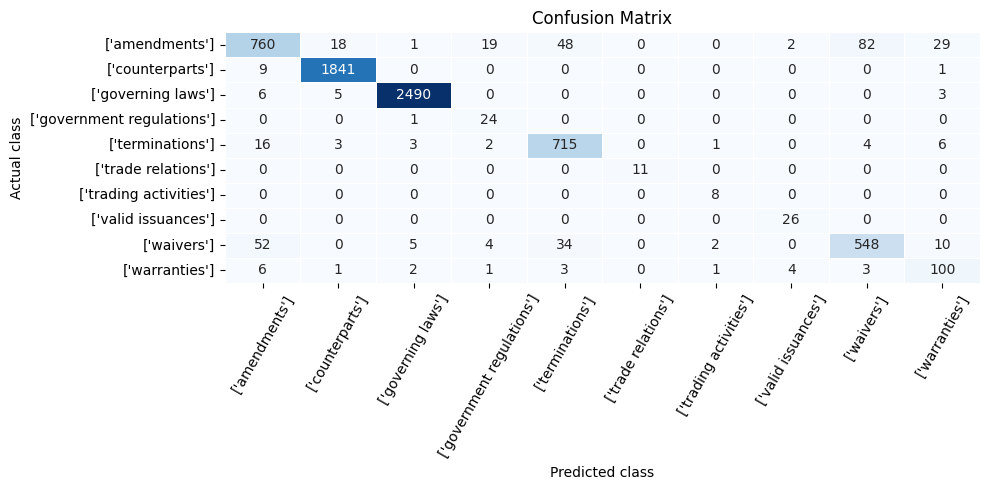

In [120]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 5))
cm = confusion_matrix(y_true, y_rf_pred)
sns.heatmap(cm, annot = True, cbar = False, fmt = "d", linewidths = .5, cmap = "Blues", ax = ax1)
ax1.set_title("Confusion Matrix")
ax1.set_xlabel("Predicted class")
ax1.set_ylabel("Actual class")
target_names=rf_model.classes_
ax1.set_xticklabels(target_names)
ax1.set_yticklabels(target_names)
ax1.tick_params(axis='x', rotation=60)
ax1.tick_params(axis='y', rotation=0)
fig.tight_layout()


### K Nearest Neighbour

In [121]:
from sklearn.neighbors import KNeighborsClassifier
k = 5  
knn_model = KNeighborsClassifier(n_neighbors=k)

knn_model.fit(X_train_res, y_train_res)

y_pred_knn = knn_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_true, y_pred_knn)}")
print(f"Classification Report:\n{classification_report(y_true, y_pred_knn)}")

Accuracy: 0.9026049204052098
Classification Report:
                            precision    recall  f1-score   support

            ['amendments']       0.81      0.83      0.82       959
          ['counterparts']       0.95      0.96      0.95      1851
        ['governing laws']       0.97      0.94      0.95      2504
['government regulations']       0.88      0.88      0.88        25
          ['terminations']       0.84      0.80      0.82       750
       ['trade relations']       1.00      1.00      1.00        11
    ['trading activities']       0.80      1.00      0.89         8
       ['valid issuances']       0.76      1.00      0.87        26
               ['waivers']       0.81      0.84      0.82       655
            ['warranties']       0.59      0.80      0.68       121

                  accuracy                           0.90      6910
                 macro avg       0.84      0.91      0.87      6910
              weighted avg       0.91      0.90      0.90     

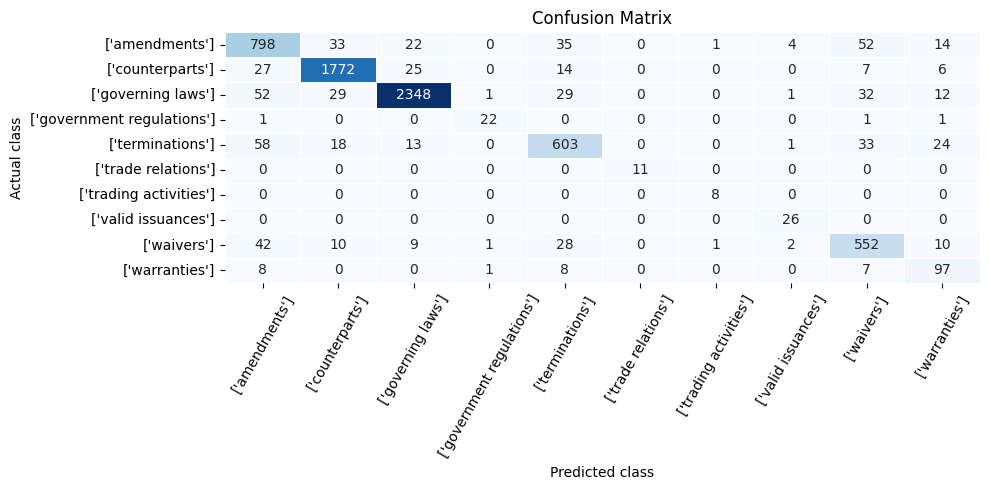

In [122]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 5))
cm = confusion_matrix(y_true, y_pred_knn)
sns.heatmap(cm, annot = True, cbar = False, fmt = "d", linewidths = .5, cmap = "Blues", ax = ax1)
ax1.set_title("Confusion Matrix")
ax1.set_xlabel("Predicted class")
ax1.set_ylabel("Actual class")
target_names=knn_model.classes_
ax1.set_xticklabels(target_names)
ax1.set_yticklabels(target_names)
ax1.tick_params(axis='x', rotation=60)
ax1.tick_params(axis='y', rotation=0)
fig.tight_layout()

Some parts of confusion matrix plotting are from https://github.com/bagheri365/ML-Models-for-Classification.git

# <font color="blue">Part B</font>

## Guideline:

**STEP 1: DATA PREPARATION**  

- Download the CUAD dataset here: https://www.atticusprojectai.org/cuad
- Read the CUAD's [Datasheet](https://drive.google.com/drive/u/0/folders/1Yu-JnZj1LbVBfTdPiHfMDnaKZj4eqks8) and understand the format of the data.

**STEP 2: MODELLING**  
- Train a machine learning model to extract expiry date from a given plaintext contract. To account for model explainability, you may also train a model to first extract the relevant clause from a contract by outputting start and end tokens, and then extract the expiry date using a rule-based extractor. 
- Perform your own train-test split.
- Choose your own evaluation metrics and explain your choice(s)
- Feel feel to employ whichever modelling techniques you see fit, e.g. question answering, custom-NER, etc.
- We highly recommend you to read CUAD's paper on arxiv: [CUAD: An Expert-Annotated NLP Dataset for Legal Contract Review](https://arxiv.org/abs/2103.06268)

- You may refer to, and/or copy code blocks from any public Github repositories, Kaggle kernels or tutorials online. However, please add a comment indicating the source.
- You are free to conduct exploratory data analysis, write unit tests or any other additional steps as you find neccesary.
- The purpose is NOT to train the best-performing model. It is to help us assess your ability to learn and apply NLP modelling techniques.

## Answer:

In [ ]:
# Begin your code here


